In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=50)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

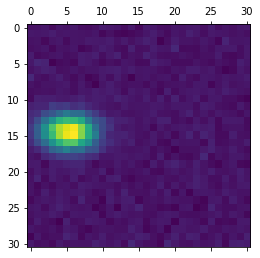

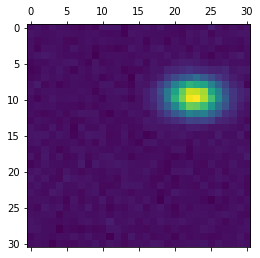

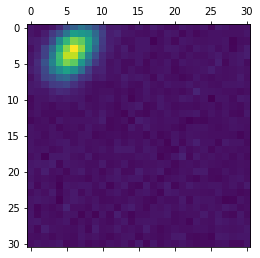

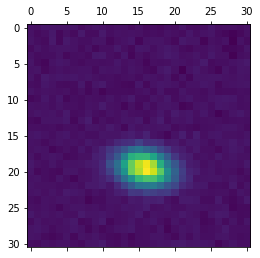

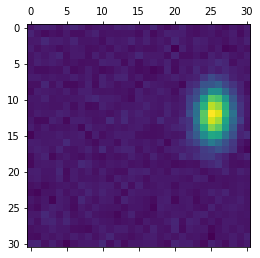

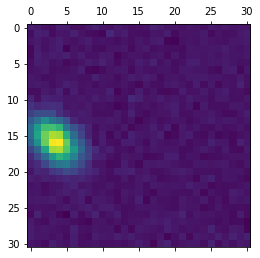

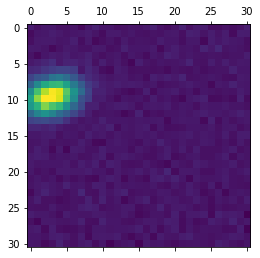

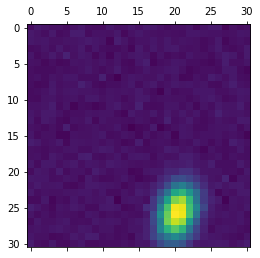

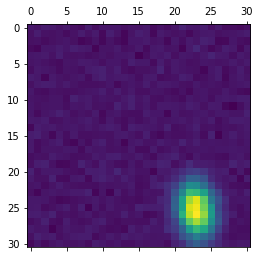

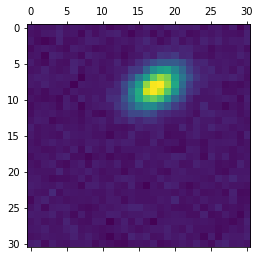

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [8]:
state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [9]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [10]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

In [11]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [12]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(images_batch1, backgrounds_batch1, 
                                                                     map_pixel_loc)

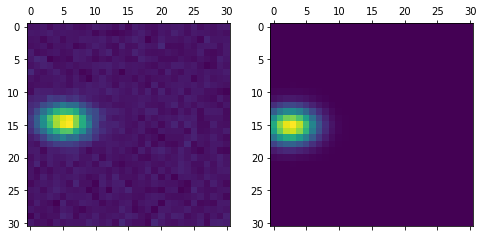

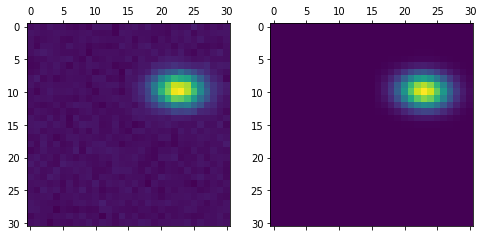

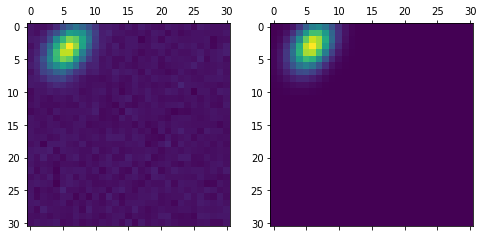

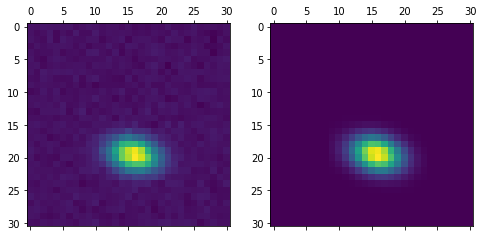

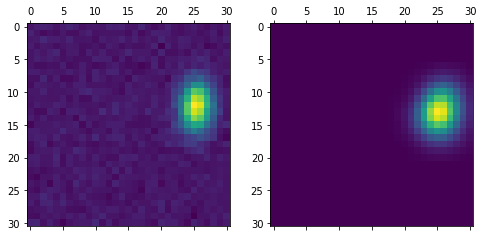

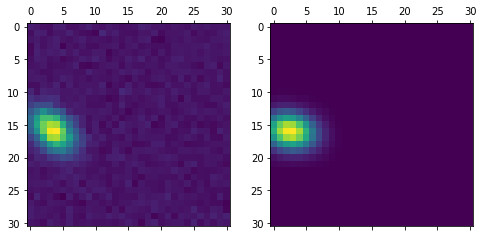

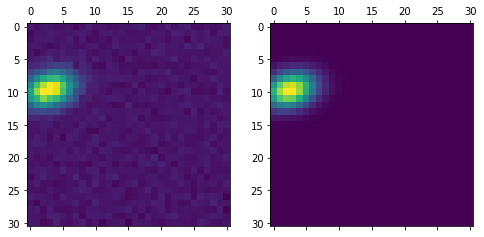

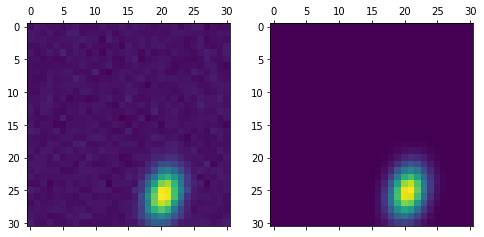

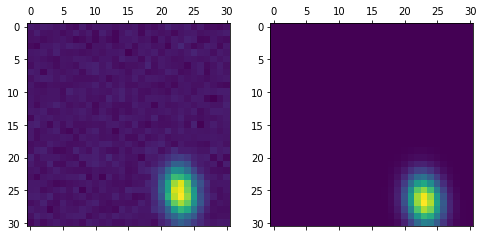

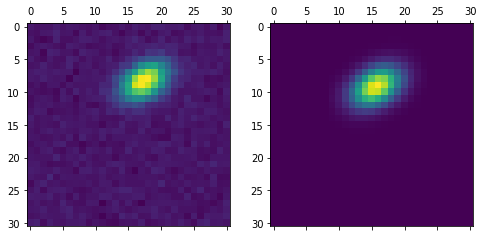

In [13]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


In [14]:
# check optimizer goes through

In [15]:
optimizer = optim.Adam(galaxy_rnn.parameters(), lr=0.001, weight_decay=1e-6)
optimizer.zero_grad()

In [16]:
pm_loss, map_loss = galaxy_rnn.get_pm_loss(images_batch1, backgrounds_batch1, alpha = 0.0, topk = 2, 
                                           use_baseline = True)

In [17]:
map_loss

tensor(1.00000e+06 *
       1.5332)

In [18]:
pm_loss.backward()

In [19]:
optimizer.step()

In [20]:
_, map_loss2 = galaxy_rnn.get_pm_loss(images_batch1, backgrounds_batch1, alpha = 0.0, topk = 2, 
                                           use_baseline = True)

In [21]:
map_loss2

tensor(1.00000e+06 *
       1.4959)

In [22]:
# Check train module

In [24]:
galaxy_lib.train_module(galaxy_rnn, train_loader, test_loader, epochs = 12, save_every = 2, 
                        alpha = 0.0, topk = 0, use_baseline = True,
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

[0] loss: 165261  	[1.0 seconds]
  * test loss: 293508
writing the network's parameters to ./test_epoch0.dat
[1] loss: 164652  	[1.2 seconds]
[2] loss: 162876  	[1.2 seconds]
  * test loss: 291924
writing the network's parameters to ./test_epoch2.dat
[3] loss: 162744  	[1.1 seconds]
[4] loss: 180077  	[1.1 seconds]
  * test loss: 288439
writing the network's parameters to ./test_epoch4.dat
[5] loss: 160778  	[1.2 seconds]
[6] loss: 161510  	[1.0 seconds]
  * test loss: 293648
writing the network's parameters to ./test_epoch6.dat
[7] loss: 165569  	[1.2 seconds]
[8] loss: 160388  	[1.1 seconds]
  * test loss: 283781
writing the network's parameters to ./test_epoch8.dat
[9] loss: 158209  	[1.3 seconds]
[10] loss: 158570  	[1.1 seconds]
  * test loss: 285545
writing the network's parameters to ./test_epoch10.dat
[11] loss: 160477  	[1.1 seconds]


In [25]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [26]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri